In [2]:
!pip install censusdata

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import censusdata
import seaborn as sns
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

/Users/jackturek/opt/anaconda3/lib/python3.8/site-packages/statsmodels/compat/pandas.py:61: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [267]:
# Download Median Income for census tracts in SATX
data = censusdata.download('acs5', 2019,
                           censusdata.censusgeo([('state', '48'),
                                                 ('county', '029'),
                                                 ('tract', '*')]),
                                                 ['B19013_001E'])
# Rename median income col
data.rename(columns={'B19013_001E': 'Median Household Income'}, inplace=True)

In [268]:
data.head(10)
data['GEOID'] = data.index.astype(str)
data.head()

,Median Household Income,GEOID
"Census Tract 1109, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:110900",83696,"Census Tract 1109, Bexar County, Texas: Summar..."
"Census Tract 1110, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:111000",42143,"Census Tract 1110, Bexar County, Texas: Summar..."
"Census Tract 1217.01, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121701",64321,"Census Tract 1217.01, Bexar County, Texas: Sum..."
"Census Tract 1211.19, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121119",60109,"Census Tract 1211.19, Bexar County, Texas: Sum..."
"Census Tract 1211.20, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121120",80171,"Census Tract 1211.20, Bexar County, Texas: Sum..."


In [269]:
# Create column for tract as geo_name
data['geo_name'] = data.index.astype(str).str.split(':').str[-1].str.split('>').str[-1].str.extract('(\d+)', expand=False)

In [270]:
data.head()

,Median Household Income,GEOID,geo_name
"Census Tract 1109, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:110900",83696,"Census Tract 1109, Bexar County, Texas: Summar...",110900
"Census Tract 1110, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:111000",42143,"Census Tract 1110, Bexar County, Texas: Summar...",111000
"Census Tract 1217.01, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121701",64321,"Census Tract 1217.01, Bexar County, Texas: Sum...",121701
"Census Tract 1211.19, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121119",60109,"Census Tract 1211.19, Bexar County, Texas: Sum...",121119
"Census Tract 1211.20, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121120",80171,"Census Tract 1211.20, Bexar County, Texas: Sum...",121120


In [271]:
data = data[['geo_name', 'Median Household Income']].copy()
data.head()

,geo_name,Median Household Income
"Census Tract 1109, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:110900",110900,83696
"Census Tract 1110, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:111000",111000,42143
"Census Tract 1217.01, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121701",121701,64321
"Census Tract 1211.19, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121119",121119,60109
"Census Tract 1211.20, Bexar County, Texas: Summary level: 140, state:48> county:029> tract:121120",121120,80171


---

# SATX City Health Dashboard Data

In [276]:
df = pd.read_csv('TX_Tract_City_07-26-2023.csv')

/var/folders/h6/yxy6glj14rd2c83llgj50xnc0000gn/T/ipykernel_65933/1833663081.py:1: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('TX_Tract_City_07-26-2023.csv')


In [277]:
df.head()

,state_abbr,state_fips,geo_fips,geo_level,geo_name,parent_fips,parent_level,parent_name,metric_name,group_name,...,denom,est,lci,uci,period_type,data_period,source_name,census_parent_shape_year,version,suggested_citation
0,TX,48,48007950101,tract,950101,4817000,city,Corpus Christi,Air Pollution - Ozone,Total,...,-999.0,35.7,-999.0,-999.0,1 month average estimate,202201,GMU,2020,07-26-2023,"Department of Population Health, NYU Langone H..."
1,TX,48,48007950101,tract,950101,4817000,city,Corpus Christi,Air Pollution - Ozone,Total,...,-999.0,37.0,-999.0,-999.0,1 month average estimate,202202,GMU,2020,07-26-2023,NaN
2,TX,48,48007950101,tract,950101,4817000,city,Corpus Christi,Air Pollution - Ozone,Total,...,-999.0,43.2,-999.0,-999.0,1 month average estimate,202203,GMU,2020,07-26-2023,NaN
3,TX,48,48007950101,tract,950101,4817000,city,Corpus Christi,Air Pollution - Ozone,Total,...,-999.0,39.3,-999.0,-999.0,1 month average estimate,202204,GMU,2020,07-26-2023,NaN
4,TX,48,48007950101,tract,950101,4817000,city,Corpus Christi,Air Pollution - Ozone,Total,...,-999.0,34.9,-999.0,-999.0,1 month average estimate,202205,GMU,2020,07-26-2023,NaN


In [278]:
# Filter for San Antonio
san_antonio = df[df['parent_name'] == 'San Antonio']

In [279]:
san_antonio.head()

,state_abbr,state_fips,geo_fips,geo_level,geo_name,parent_fips,parent_level,parent_name,metric_name,group_name,...,denom,est,lci,uci,period_type,data_period,source_name,census_parent_shape_year,version,suggested_citation
888,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,31.0,-999.0,-999.0,1 month average estimate,202201,GMU,2020,07-26-2023,NaN
889,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,35.8,-999.0,-999.0,1 month average estimate,202202,GMU,2020,07-26-2023,NaN
890,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,43.5,-999.0,-999.0,1 month average estimate,202203,GMU,2020,07-26-2023,NaN
891,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,41.1,-999.0,-999.0,1 month average estimate,202204,GMU,2020,07-26-2023,NaN
892,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,43.1,-999.0,-999.0,1 month average estimate,202205,GMU,2020,07-26-2023,NaN


In [280]:
san_antonio.metric_name.unique()

array(['Air Pollution - Ozone', 'Air Pollution - Particulate Matter',
       'Binge Drinking', 'Broadband Connection', 'Children in Poverty',
       'Credit Insecurity Index', 'Dental Care', 'Diabetes',
       'Frequent Mental Distress', 'Frequent Physical Distress',
       'High Blood Pressure', 'High School Completion',
       'Housing with Potential Lead Risk', 'Income Inequality',
       'Lead Exposure Risk Index', 'Life Expectancy', 'Obesity',
       'Park Access', 'Physical Inactivity', 'Preventive Services, 65+',
       'Racial/Ethnic Diversity', 'Rent Burden', 'Routine Checkup, 18+',
       'Smoking', 'Unemployment - Annual, Neighborhood-Level',
       'Uninsured', 'Walkability'], dtype=object)

In [281]:
# Filter for metrics
metrics = ['Air Pollution - Ozone', 'Air Pollution - Particulate Matter']

satx_filtered =  san_antonio[san_antonio['metric_name'].isin(metrics)]         

In [282]:
satx_filtered.head()

,state_abbr,state_fips,geo_fips,geo_level,geo_name,parent_fips,parent_level,parent_name,metric_name,group_name,...,denom,est,lci,uci,period_type,data_period,source_name,census_parent_shape_year,version,suggested_citation
888,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,31.0,-999.0,-999.0,1 month average estimate,202201,GMU,2020,07-26-2023,NaN
889,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,35.8,-999.0,-999.0,1 month average estimate,202202,GMU,2020,07-26-2023,NaN
890,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,43.5,-999.0,-999.0,1 month average estimate,202203,GMU,2020,07-26-2023,NaN
891,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,41.1,-999.0,-999.0,1 month average estimate,202204,GMU,2020,07-26-2023,NaN
892,TX,48,48029110100,tract,110100,4865000,city,San Antonio,Air Pollution - Ozone,Total,...,-999.0,43.1,-999.0,-999.0,1 month average estimate,202205,GMU,2020,07-26-2023,NaN


In [283]:
# Pivot table for one row per census tract & one column per metric
satx_pivot = satx_filtered.pivot_table(index=['geo_name', 'data_period'],
                                       columns='metric_name',
                                       values='est')

In [284]:
satx_pivot.head(30)

metric_name           Air Pollution - Ozone  \
geo_name data_period                          
104      202201                        34.6   
         202202                        38.5   
         202203                        44.8   
         202204                        41.1   
         202205                        41.2   
         202206                        39.1   
         202207                        36.4   
         202208                        35.0   
         202209                        49.2   
         202210                        50.2   
         202211                        32.2   
         202212                        30.5   
110100   202201                        31.0   
         202202                        35.8   
         202203                        43.5   
         202204                        41.1   
         202205                        43.1   
         202206                        42.8   
         202207                        41.2   
         202208                        40.5   
         202209                        52.8   
         202210                        50.0   
         202211                        29.7   
         202212                        27.6   
110300   202201                        31.0   
         202202                        35.8   
         202203                        43.5   
         202204                        41.1   
         202205                        43.1   
         202206                        42.8   

metric_name           Air Pollution - Particulate Matter  
geo_name data_period                                      
104      202201                                      8.4  
         202202                                      7.3  
         202203                                      8.6  
         202204                                     10.1  
         202205                                     10.2  
         202206                                     10.5  
         202207                                      8.4  
         202208                                      6.4  
         202209                                      7.1  
         202210                                      8.1  
         202211                                      6.0  
         202212                                      7.5  
110100   202201                                     10.8  
         202202                                      9.0  
         202203                                     10.1  
         202204                                     13.5  
         202205                                     15.6  
         202206                                     16.5  
         202207                                     13.2  
         202208                                     10.6  
         202209                                     12.3  
         202210                                     10.2  
         202211                                      9.2  
         202212                                     11.8  
110300   202201                                     10.8  
         202202                                      9.0  
         202203                                     10.1  
         202204                                     13.5  
         202205                                     15.6  
         202206                                     16.5

In [285]:
# Reset index
satx_pivot.reset_index(inplace=True)

In [286]:
satx_pivot

metric_name,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter
0,104,202201,34.6,8.4
1,104,202202,38.5,7.3
2,104,202203,44.8,8.6
3,104,202204,41.1,10.1
4,104,202205,41.2,10.2
...,...,...,...,...
4243,980100,202208,40.5,10.6
4244,980100,202209,52.8,12.3
4245,980100,202210,50.0,10.2
4246,980100,202211,29.7,9.2


## Merge satx_pivot and census median income data

In [287]:

satx_pivot.geo_name.dtype
data.geo_name.dtype

dtype('O')

In [288]:
data['geo_name'] = data['geo_name'].astype('int64')

In [289]:
satx_merged = pd.merge(satx_pivot, data, on='geo_name', how='left')

In [290]:
# Drop NaNs
satx_merged = satx_merged.dropna(subset=['Median Household Income'])

In [291]:
satx_merged.head()

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income
12,110100,202201,31.0,10.8,50865.0
13,110100,202202,35.8,9.0,50865.0
14,110100,202203,43.5,10.1,50865.0
15,110100,202204,41.1,13.5,50865.0
16,110100,202205,43.1,15.6,50865.0


In [292]:
# Sort median household income
satx_merged = satx_merged.sort_values('Median Household Income')

In [295]:
satx_merged = satx_merged.loc[satx_merged['Median Household Income'] > 0]

In [296]:
satx_merged.head()

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income
46,110500,202211,29.7,9.2,10463.0
47,110500,202212,27.6,11.8,10463.0
44,110500,202209,52.8,12.3,10463.0
43,110500,202208,40.5,10.6,10463.0
42,110500,202207,41.2,13.2,10463.0


In [297]:
unique_tracts =  satx_merged.groupby('geo_name')['Median Household Income'].median()

In [298]:
unique_tracts.head()

geo_name
110100    50865.0
110300    32356.0
110500    10463.0
110600    15250.0
110700    18256.0
Name: Median Household Income, dtype: float64

In [299]:
# Get geo_name for 5 smallest and 5 largest
lowest_tracts = unique_tracts.nsmallest(5).index
highest_tracts = unique_tracts.nlargest(5).index
lowest_tracts

Int64Index([110500, 110600, 150800, 110700, 160501], dtype='int64', name='geo_name')

In [300]:
lowest_income = satx_merged[satx_merged['geo_name'].isin(lowest_tracts)]
highest_income = satx_merged[satx_merged['geo_name'].isin(highest_tracts)]

In [302]:
print(lowest_income.head())
print()
print(highest_income.head())

    geo_name  data_period  Air Pollution - Ozone  \
46    110500       202211                   29.7   
47    110500       202212                   27.6   
44    110500       202209                   52.8   
43    110500       202208                   40.5   
42    110500       202207                   41.2   

    Air Pollution - Particulate Matter  Median Household Income  
46                                 9.2                  10463.0  
47                                11.8                  10463.0  
44                                12.3                  10463.0  
43                                10.6                  10463.0  
42                                13.2                  10463.0  

      geo_name  data_period  Air Pollution - Ozone  \
3955    191806       202208                   42.1   
3949    191806       202202                   37.5   
3950    191806       202203                   45.9   
3951    191806       202204                   43.0   
3952    191806      

In [303]:
# Combine lowest/highest income dataframes
lowest_income['Income Group'] = 'Lowest'
highest_income['Income Group'] = 'Highest'

/var/folders/h6/yxy6glj14rd2c83llgj50xnc0000gn/T/ipykernel_65933/3153867080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lowest_income['Income Group'] = 'Lowest'
/var/folders/h6/yxy6glj14rd2c83llgj50xnc0000gn/T/ipykernel_65933/3153867080.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  highest_income['Income Group'] = 'Highest'


In [304]:
combined_df = pd.concat([lowest_income, highest_income])

In [305]:
combined_df

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Group
46,110500,202211,29.7,9.2,10463.0,Lowest
47,110500,202212,27.6,11.8,10463.0,Lowest
44,110500,202209,52.8,12.3,10463.0,Lowest
43,110500,202208,40.5,10.6,10463.0,Lowest
42,110500,202207,41.2,13.2,10463.0,Lowest
...,...,...,...,...,...,...
3884,191504,202209,52.9,8.6,215083.0,Highest
3885,191504,202210,50.1,10.1,215083.0,Highest
3886,191504,202211,30.1,6.5,215083.0,Highest
3877,191504,202202,35.4,8.0,215083.0,Highest


In [306]:
# Convert data_period to datetime format
combined_df['data_period'] = pd.to_datetime(combined_df['data_period'], format='%Y%m')

In [307]:
combined_df = combined_df.sort_values(['geo_name', 'data_period'])

In [308]:
combined_df.geo_name.unique()

array([110500, 110600, 110700, 150800, 160501, 190800, 191412, 191504,
       191505, 191806])

In [309]:
combined_df

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Group
36,110500,2022-01-01,31.0,10.8,10463.0,Lowest
37,110500,2022-02-01,35.8,9.0,10463.0,Lowest
38,110500,2022-03-01,43.5,10.1,10463.0,Lowest
39,110500,2022-04-01,41.1,13.5,10463.0,Lowest
40,110500,2022-05-01,43.1,15.6,10463.0,Lowest
...,...,...,...,...,...,...
3955,191806,2022-08-01,42.1,5.2,145579.0,Highest
3956,191806,2022-09-01,51.4,6.9,145579.0,Highest
3957,191806,2022-10-01,50.7,8.7,145579.0,Highest
3958,191806,2022-11-01,31.9,5.4,145579.0,Highest


In [310]:
combined_df['data_period'] = combined_df['data_period'].astype(str)

In [311]:
combined_df['data_period'] = combined_df['data_period'].str.slice(0,7)

In [312]:
combined_df.head()

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Group
36,110500,2022-01,31.0,10.8,10463.0,Lowest
37,110500,2022-02,35.8,9.0,10463.0,Lowest
38,110500,2022-03,43.5,10.1,10463.0,Lowest
39,110500,2022-04,41.1,13.5,10463.0,Lowest
40,110500,2022-05,43.1,15.6,10463.0,Lowest


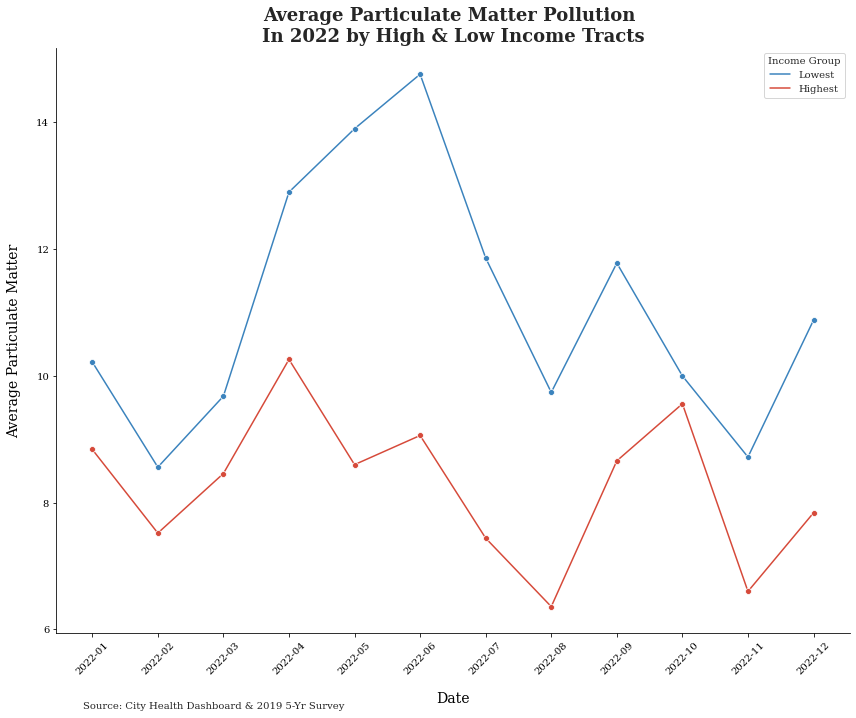

In [367]:
# Set style & plot
sns.set_style("ticks", {
    'axes.edgecolor': '0',
    'font.family': ['serif'],
    'axes.labelcolor': '0',
    'xtick.color': '0',
    'ytick.color': '0'
})

plt.figure(figsize=(12,10))

# Plot
ax = sns.lineplot(data=combined_df, x = 'data_period', y = 'Air Pollution - Particulate Matter', hue = 'Income Group', palette = ['#3B83BD', '#D64A3A'], marker='o', ci=None)
plt.title('Average Particulate Matter Pollution \nIn 2022 by High & Low Income Tracts', fontsize=18, fontweight='bold', loc='center')
plt.xlabel('Date', fontsize=14, labelpad=15)
plt.ylabel('Average Particulate Matter', fontsize=14, labelpad=15)

# X-tick labels rotation
ax.set_xticks(combined_df['data_period'].unique())
ax.set_xticklabels(combined_df['data_period'].unique(), rotation=45)

sns.despine()
plt.figtext(0.1, 0.01, 'Source: City Health Dashboard & 2019 5-Yr Survey')
plt.tight_layout()
plt.legend(title='Income Group')
plt.show()

---


In [314]:
# Check original shape
satx_merged.shape

(3900, 5)

In [315]:
# Order df
satx_merged = satx_merged.sort_values(by=['geo_name', 'data_period'])
satx_merged

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income
12,110100,202201,31.0,10.8,50865.0
13,110100,202202,35.8,9.0,50865.0
14,110100,202203,43.5,10.1,50865.0
15,110100,202204,41.1,13.5,50865.0
16,110100,202205,43.1,15.6,50865.0
...,...,...,...,...,...
4243,980100,202208,40.5,10.6,48125.0
4244,980100,202209,52.8,12.3,48125.0
4245,980100,202210,50.0,10.2,48125.0
4246,980100,202211,29.7,9.2,48125.0


In [316]:
# Create income levels
income_levels = [0, 30000, 60000, 90000, 120000, 150000, 180000, 210000]
income_labels = ['0-30k', '30k-60k', '60k-90k', '90k-120k', '120k-150k', '150k-180k', '180k-210k']

In [317]:
# Add income levels to satx_merged
satx_merged['Income Range'] = pd.cut(satx_merged['Median Household Income'], bins=income_levels, labels=income_labels, right=False)

In [318]:
satx_merged.head()

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Range
12,110100,202201,31.0,10.8,50865.0,30k-60k
13,110100,202202,35.8,9.0,50865.0,30k-60k
14,110100,202203,43.5,10.1,50865.0,30k-60k
15,110100,202204,41.1,13.5,50865.0,30k-60k
16,110100,202205,43.1,15.6,50865.0,30k-60k


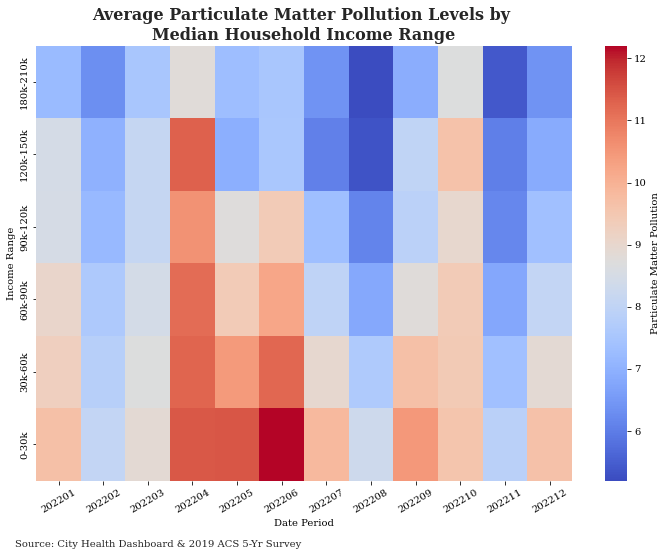

In [319]:
# Heatmap - Particulate Matter
heatmap_pm25 = satx_merged.pivot_table(values='Air Pollution - Particulate Matter',
                                        index='Income Range',
                                        columns='data_period')

heatmap_pm25 = heatmap_pm25.sort_index(ascending=False)

# Plot
plt.figure(figsize=(12,8))
sns.heatmap(heatmap_pm25, cmap='coolwarm', cbar_kws={'label': 'Particulate Matter Pollution'})
plt.title(" Particulate Matter Pollution Levels by \nMedian Household Income Range", fontsize=16, fontweight='bold', loc='center')
plt.xticks(rotation=30)
plt.xlabel('Date Period')
plt.figtext(0.1, 0.01, 'Source: City Health Dashboard & 2019 ACS 5-Yr Survey')
plt.show()

---

## CDC PLACES Health Data

In [320]:
places_data = pd.read_csv('PLACES_HealthData.csv')

In [321]:
satx_places = places_data[(places_data['CountyName'] == 'Bexar') & (places_data['StateAbbr'] == 'TX')]

In [322]:
satx_places['TractFIPS'] = satx_places['TractFIPS'].astype(str).str[-6:].astype(int)
satx_places.head()

/var/folders/h6/yxy6glj14rd2c83llgj50xnc0000gn/T/ipykernel_65933/2189654140.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  satx_places['TractFIPS'] = satx_places['TractFIPS'].astype(str).str[-6:].astype(int)


,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
53090,TX,Texas,Bexar,48029,121809,4982,25.0,"(22.1, 27.6)",20.1,"(19.3, 21.0)",...,"(36.3, 38.7)",9.4,"( 8.7, 10.2)",35.7,"(34.5, 36.9)",2.3,"( 2.1, 2.5)",11.0,"( 7.6, 14.9)",POINT (-98.38215125 29.57808674)
53103,TX,Texas,Bexar,48029,181722,4540,23.9,"(21.1, 26.9)",16.7,"(15.9, 17.4)",...,"(34.9, 37.4)",7.9,"( 7.2, 8.5)",34.6,"(33.3, 35.9)",1.8,"( 1.6, 1.9)",7.7,"( 5.8, 10.0)",POINT (-98.67257075 29.51344015)
53141,TX,Texas,Bexar,48029,121115,5141,18.9,"(16.3, 21.8)",23.6,"(22.2, 24.9)",...,"(34.1, 37.0)",9.5,"( 8.4, 10.8)",32.9,"(31.4, 34.4)",2.6,"( 2.3, 3.0)",9.5,"( 5.7, 14.3)",POINT (-98.45341942 29.57537954)
53149,TX,Texas,Bexar,48029,161100,8623,48.7,"(43.2, 54.3)",20.3,"(19.2, 21.3)",...,"(43.9, 46.6)",14.2,"(12.9, 15.7)",37.6,"(36.3, 38.9)",3.1,"( 2.7, 3.4)",17.6,"(13.9, 21.7)",POINT (-98.57591898 29.32753592)
53197,TX,Texas,Bexar,48029,171918,5185,27.4,"(24.0, 30.7)",13.0,"(12.4, 13.6)",...,"(34.8, 37.2)",7.3,"( 6.7, 8.0)",36.2,"(34.9, 37.5)",1.4,"( 1.3, 1.6)",9.0,"( 6.3, 11.8)",POINT (-98.69592738 29.45709968)


In [323]:
satx_places.reset_index(drop=True, inplace=True)
satx_places.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TractFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,...,OBESITY_Crude95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,STROKE_CrudePrev,STROKE_Crude95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,Geolocation
0,TX,Texas,Bexar,48029,121809,4982,25.0,"(22.1, 27.6)",20.1,"(19.3, 21.0)",...,"(36.3, 38.7)",9.4,"( 8.7, 10.2)",35.7,"(34.5, 36.9)",2.3,"( 2.1, 2.5)",11.0,"( 7.6, 14.9)",POINT (-98.38215125 29.57808674)
1,TX,Texas,Bexar,48029,181722,4540,23.9,"(21.1, 26.9)",16.7,"(15.9, 17.4)",...,"(34.9, 37.4)",7.9,"( 7.2, 8.5)",34.6,"(33.3, 35.9)",1.8,"( 1.6, 1.9)",7.7,"( 5.8, 10.0)",POINT (-98.67257075 29.51344015)
2,TX,Texas,Bexar,48029,121115,5141,18.9,"(16.3, 21.8)",23.6,"(22.2, 24.9)",...,"(34.1, 37.0)",9.5,"( 8.4, 10.8)",32.9,"(31.4, 34.4)",2.6,"( 2.3, 3.0)",9.5,"( 5.7, 14.3)",POINT (-98.45341942 29.57537954)
3,TX,Texas,Bexar,48029,161100,8623,48.7,"(43.2, 54.3)",20.3,"(19.2, 21.3)",...,"(43.9, 46.6)",14.2,"(12.9, 15.7)",37.6,"(36.3, 38.9)",3.1,"( 2.7, 3.4)",17.6,"(13.9, 21.7)",POINT (-98.57591898 29.32753592)
4,TX,Texas,Bexar,48029,171918,5185,27.4,"(24.0, 30.7)",13.0,"(12.4, 13.6)",...,"(34.8, 37.2)",7.3,"( 6.7, 8.0)",36.2,"(34.9, 37.5)",1.4,"( 1.3, 1.6)",9.0,"( 6.3, 11.8)",POINT (-98.69592738 29.45709968)


In [324]:
# PLACES variables - BPHIGH_CrudePrev; CASTHMA_CrudePrev; CHD_CrudePrev; DIABETES_CrudePrev; OBESITY_CrudePrev; STROKE_CrudePrev
keep_columns = ['TractFIPS', 'TotalPopulation', 'BPHIGH_CrudePrev', 'CASTHMA_CrudePrev', 'CHD_CrudePrev', 'DIABETES_CrudePrev', 'OBESITY_CrudePrev', 'STROKE_CrudePrev']
satx_places = satx_places[keep_columns]
satx_places.head()


,TractFIPS,TotalPopulation,BPHIGH_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev
0,121809,4982,32.4,8.7,5.1,10.7,37.5,2.3
1,181722,4540,28.7,8.2,4.0,9.6,36.2,1.8
2,121115,5141,35.7,8.7,6.3,11.2,35.5,2.6
3,161100,8623,35.1,9.2,6.5,17.4,45.3,3.1
4,171918,5185,24.4,8.4,3.0,7.6,36.0,1.4


In [325]:
# Rename TractFIPS to geo_name in prep for future join
satx_places = satx_places.rename(columns={'TractFIPS': 'geo_name'})

In [326]:
satx_places.head()

,geo_name,TotalPopulation,BPHIGH_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev
0,121809,4982,32.4,8.7,5.1,10.7,37.5,2.3
1,181722,4540,28.7,8.2,4.0,9.6,36.2,1.8
2,121115,5141,35.7,8.7,6.3,11.2,35.5,2.6
3,161100,8623,35.1,9.2,6.5,17.4,45.3,3.1
4,171918,5185,24.4,8.4,3.0,7.6,36.0,1.4


In [327]:
satx_merged

,geo_name,data_period,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Range
12,110100,202201,31.0,10.8,50865.0,30k-60k
13,110100,202202,35.8,9.0,50865.0,30k-60k
14,110100,202203,43.5,10.1,50865.0,30k-60k
15,110100,202204,41.1,13.5,50865.0,30k-60k
16,110100,202205,43.1,15.6,50865.0,30k-60k
...,...,...,...,...,...,...
4243,980100,202208,40.5,10.6,48125.0,30k-60k
4244,980100,202209,52.8,12.3,48125.0,30k-60k
4245,980100,202210,50.0,10.2,48125.0,30k-60k
4246,980100,202211,29.7,9.2,48125.0,30k-60k


In [328]:
# Group by tract
satx_chd = satx_merged.groupby('geo_name').agg({
    'Air Pollution - Ozone': 'mean',
    'Air Pollution - Particulate Matter': 'mean',
    'Median Household Income': 'first',
    'Income Range': 'first'
}).reset_index()

In [329]:
satx_chd

,geo_name,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Range
0,110100,39.925000,11.900000,50865.0,30k-60k
1,110300,39.925000,11.900000,32356.0,30k-60k
2,110500,39.925000,11.900000,10463.0,0-30k
3,110600,39.925000,11.900000,15250.0,0-30k
4,110700,39.925000,11.900000,18256.0,0-30k
...,...,...,...,...,...
320,192100,39.925000,11.900000,73194.0,60k-90k
321,192200,39.066667,6.966667,41623.0,30k-60k
322,192300,40.800000,7.750000,79113.0,60k-90k
323,980003,38.758333,10.741667,59722.0,30k-60k


In [330]:
# Merge satx_places with city health dashboard data
chd_places_merged = pd.merge(satx_places, satx_chd, on='geo_name', how='inner')

In [331]:
chd_places_merged

,geo_name,TotalPopulation,BPHIGH_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Range
0,121809,4982,32.4,8.7,5.1,10.7,37.5,2.3,40.250000,9.158333,74828.0,60k-90k
1,181722,4540,28.7,8.2,4.0,9.6,36.2,1.8,40.758333,8.816667,91250.0,90k-120k
2,121115,5141,35.7,8.7,6.3,11.2,35.5,2.6,40.250000,9.158333,79743.0,60k-90k
3,161100,8623,35.1,9.2,6.5,17.4,45.3,3.1,38.841667,7.816667,44953.0,30k-60k
4,171918,5185,24.4,8.4,3.0,7.6,36.0,1.4,39.600000,10.283333,62469.0,60k-90k
...,...,...,...,...,...,...,...,...,...,...,...,...
320,181404,4550,24.3,7.5,4.1,6.9,28.1,1.8,40.800000,7.750000,60500.0,60k-90k
321,181729,3443,18.8,8.0,1.9,5.0,33.6,0.9,39.883333,7.658333,105853.0,90k-120k
322,140100,1645,34.9,8.6,6.4,15.7,42.5,2.9,39.925000,11.900000,48295.0,30k-60k
323,191413,6032,29.2,8.7,4.5,9.0,35.4,1.9,40.800000,7.750000,74861.0,60k-90k


In [334]:
# Adjust Income Range groupings
bins = [0, 50000, 100000, 150000, float('inf')]
labels = ['$0-50k', '$51-100K', '$101-150K', '$151+']

chd_places_merged['Income Group'] = pd.cut(chd_places_merged['Median Household Income'], bins=bins, labels=labels, right=False)

In [335]:
chd_places_merged.head()

,geo_name,TotalPopulation,BPHIGH_CrudePrev,CASTHMA_CrudePrev,CHD_CrudePrev,DIABETES_CrudePrev,OBESITY_CrudePrev,STROKE_CrudePrev,Air Pollution - Ozone,Air Pollution - Particulate Matter,Median Household Income,Income Range,Income Group
0,121809,4982,32.4,8.7,5.1,10.7,37.5,2.3,40.250000,9.158333,74828.0,60k-90k,$51-100K
1,181722,4540,28.7,8.2,4.0,9.6,36.2,1.8,40.758333,8.816667,91250.0,90k-120k,$51-100K
2,121115,5141,35.7,8.7,6.3,11.2,35.5,2.6,40.250000,9.158333,79743.0,60k-90k,$51-100K
3,161100,8623,35.1,9.2,6.5,17.4,45.3,3.1,38.841667,7.816667,44953.0,30k-60k,$0-50k
4,171918,5185,24.4,8.4,3.0,7.6,36.0,1.4,39.600000,10.283333,62469.0,60k-90k,$51-100K


In [343]:
# Create quartiles for Income
q1 = chd_places_merged['Median Household Income'].quantile(0.25)
q2 = chd_places_merged['Median Household Income'].quantile(0.50)
q3 = chd_places_merged['Median Household Income'].quantile(0.75)
q4 = chd_places_merged['Median Household Income'].quantile(1.00)

In [344]:
bins = [0, q1, q2, q3, q4]
labels = ['0-25%', '25-50%', '50-75%', '75-100%']
chd_places_merged['Income Quartile'] = pd.cut(chd_places_merged['Median Household Income'], bins=bins, labels=labels, include_lowest=True)

In [368]:
# Show income ranges by quartile
income_ranges = chd_places_merged.groupby(pd.cut(chd_places_merged['Median Household Income'], bins=bins)).agg(
    min_income=('Median Household Income', 'min'),
    max_income=('Median Household Income', 'max')
).reset_index()

print(income_ranges)

  Median Household Income  min_income  max_income
0          (0.0, 38175.0]     10463.0     38175.0
1      (38175.0, 49091.0]     38323.0     49091.0
2      (49091.0, 73902.0]     49821.0     73902.0
3     (73902.0, 215083.0]     74674.0    215083.0


In [372]:
# Number of tracts in each quartile
print(chd_places_merged['Income Quartile'].value_counts().sort_index())

0-25%      82
25-50%     81
50-75%     81
75-100%    81
Name: Income Quartile, dtype: int64


In [377]:
income_group_colors = {
    'Quartile 1': 'red',
    'Quartile 2': 'orange',
    'Quartile 3': 'green',
    'Quartile 4': 'blue'
}

In [375]:
# Change quartile values
quartile_map = {
    '0-25%': 'Quartile 1',
    '25-50%': 'Quartile 2',
    '50-75%': 'Quartile 3',
    '75-100%': 'Quartile 4'
}

chd_places_merged['Income Quartile'] = chd_places_merged['Income Quartile'].replace(quartile_map)

print(chd_places_merged.head())


   geo_name  TotalPopulation  BPHIGH_CrudePrev  CASTHMA_CrudePrev  \
0    121809             4982              32.4                8.7   
1    181722             4540              28.7                8.2   
2    121115             5141              35.7                8.7   
3    161100             8623              35.1                9.2   
4    171918             5185              24.4                8.4   

   CHD_CrudePrev  DIABETES_CrudePrev  OBESITY_CrudePrev  STROKE_CrudePrev  \
0            5.1                10.7               37.5               2.3   
1            4.0                 9.6               36.2               1.8   
2            6.3                11.2               35.5               2.6   
3            6.5                17.4               45.3               3.1   
4            3.0                 7.6               36.0               1.4   

   Air Pollution - Ozone  Air Pollution - Particulate Matter  \
0              40.250000                            9.1583

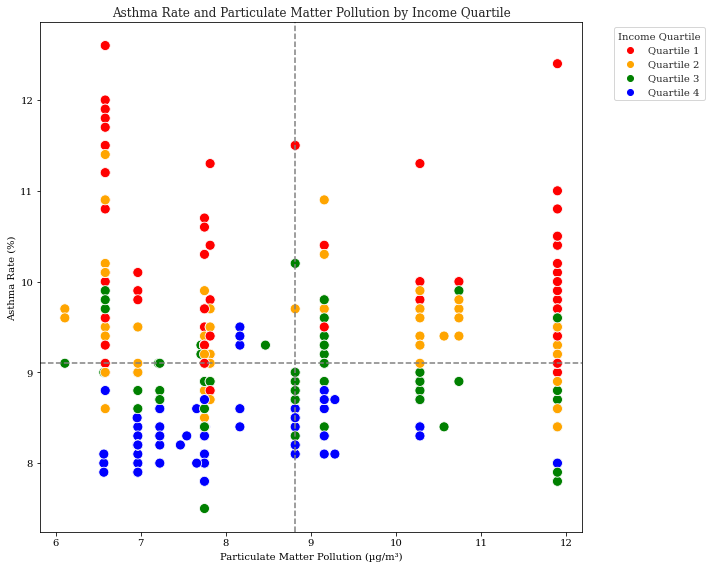

In [378]:
# Quad plot comparison - Particulate Matter & Asthma
plt.figure(figsize=(10, 8))
plot = sns.scatterplot(x='Air Pollution - Particulate Matter', y='CASTHMA_CrudePrev', hue='Income Quartile', 
                       data=chd_places_merged, palette=income_group_colors, s=100)

median_x = np.median(chd_places_merged['Air Pollution - Particulate Matter'])
median_y = np.median(chd_places_merged['CASTHMA_CrudePrev'])

plot.axvline(x=median_x, color='grey', linestyle='--')
plot.axhline(y=median_y, color='grey', linestyle='--')

plt.title('Asthma Rate and Particulate Matter Pollution by Income Quartile')
plt.xlabel('Particulate Matter Pollution (µg/m³)')
plt.ylabel('Asthma Rate (%)')
plt.legend(title='Income Quartile', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

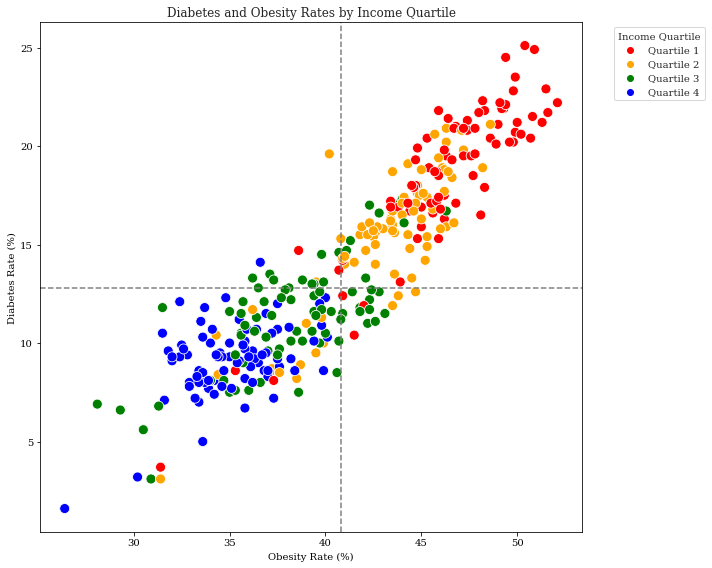

In [379]:
# Quad plot comparison - Obesity & Diabetes
plt.figure(figsize=(10, 8))
plot = sns.scatterplot(x='OBESITY_CrudePrev', y='DIABETES_CrudePrev', hue='Income Quartile', 
                       data=chd_places_merged, palette=income_group_colors, s=100)

median_x = np.median(chd_places_merged['OBESITY_CrudePrev'])
median_y = np.median(chd_places_merged['DIABETES_CrudePrev'])

plot.axvline(x=median_x, color='grey', linestyle='--')
plot.axhline(y=median_y, color='grey', linestyle='--')

plt.title('Diabetes and Obesity Rates by Income Quartile')
plt.xlabel('Obesity Rate (%)')
plt.ylabel('Diabetes Rate (%)')

plt.legend(title='Income Quartile', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()

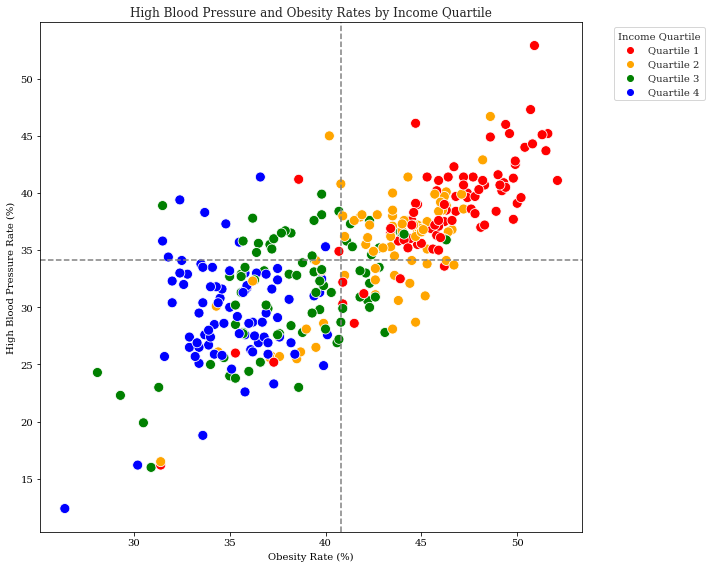

In [380]:
# Quad plot comparison - Obesity & High Blood Pressure
plt.figure(figsize=(10, 8))
plot = sns.scatterplot(x='OBESITY_CrudePrev', y='BPHIGH_CrudePrev', hue='Income Quartile', 
                       data=chd_places_merged, palette=income_group_colors, s=100)

median_x = np.median(chd_places_merged['OBESITY_CrudePrev'])
median_y = np.median(chd_places_merged['BPHIGH_CrudePrev'])

plot.axvline(x=median_x, color='grey', linestyle='--')
plot.axhline(y=median_y, color='grey', linestyle='--')

plt.title('High Blood Pressure and Obesity Rates by Income Quartile')
plt.xlabel('Obesity Rate (%)')
plt.ylabel('High Blood Pressure Rate (%)')

plt.legend(title='Income Quartile', bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.tight_layout()
plt.show()